# Построение оптимальной модели для выбора подходящего тарифа

**Описание проекта**

Заказчик - оператор мобильной связи «Мегалайн» выяснил, что многие клиенты пользуются архивными тарифами. Оператор хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 

**Описание данных**

Согласно документации к данным:

   * `сalls` — количество звонков,
   * `minutes` — суммарная длительность звонков в минутах,
   * `messages` — количество sms-сообщений,
   * `mb_used` — израсходованный интернет-трафик в Мб,
   * `is_ultra` — каким тарифом пользовался абонент в течение месяца («Ультра» — 1, «Смарт» — 0).


**Цель исследования**

Построить модель для задачи классификации, которая выберет подходящий тариф.
Необходимо построить модель с максимально большим значением accuracy - не менее 0.75. 

 **Ход исследования**
 
Входные данные получим из файла `/datasets/users_behavior.csv`.
По условию данные уже предобработаны и подготовлены для построения модели. 



## Обзор данных

Импортируем все необходимые для построения моделей библиотеки. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Прочитаем файл:

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [3]:
df = pd.read_csv('/Users/sofyabelaya/Downloads/users_behavior.csv')

Познакомимся с данными. Для этого создадим функцию, которая выводит общую информацию о данных, проверяет данные на пропуски и дубликаты, а также знакомит нас с основными статистическими характеристиками данных:

In [4]:
def df_info(df):
    print('Познакомимся с данными')
    display(df.head())
    print()
    print('Посмотрим сводную информация о данных')
    print()
    df.info()
    print()
    print("Проверим данные на пропуски и дубликаты")
    print()
    print("Доля пропусков:")
    display(df.isna().mean())
    print()
    print("Количество дубликатов:", df.duplicated().sum()) 
    print()
    print("Сводка статистики ")  
    display(df.describe())     

Посмотрим эту информацию:

In [5]:
df_info(df)

Познакомимся с данными


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



Посмотрим сводную информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB

Проверим данные на пропуски и дубликаты

Доля пропусков:


calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64


Количество дубликатов: 0

Сводка статистики 


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Итак, в таблице с данными 5 столбцов и 3214 строк. 
Каждый объект в наборе данных - это информация поведении 3214 пользователей за месяц: подключенный тариф, количество и продолжительность звонков, количество отправленных сообщений и израсходованного трафика.

**Вывод**

Известно, что данные уже предобработаны и готовы к построению модели. Но мы видим, что в каждом столбце есть нулевые значения и выбросы, поэтому предварительно проведем разведочный анализ данных.

## Разведочный анализ данных

Для начала посмотрим распределение данных по каждому параметру на гистограммах. Для этого напишем функцию.

In [6]:
def build_plot(column, title, xlabel):
    '''
    Функция принимает значения столбца и строит график,
    а также присваивает название заголока и оси x
    '''
    sns.set_style("darkgrid")
    sns.displot(df[column], bins=50, kde=True, color='teal')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()
    print()
    print('Доля данных с нулевым значением:', (df.loc[df[column] == 0][column].count() / len(df)).round(2))

Распределение данных:

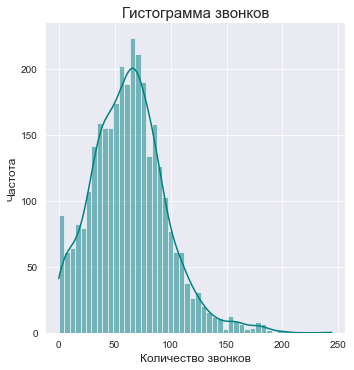


Доля данных с нулевым значением: 0.01


In [7]:
build_plot('calls', 'Гистограмма звонков', 'Количество звонков')

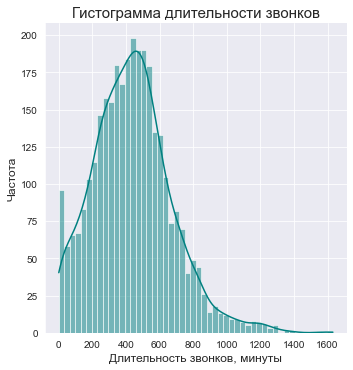


Доля данных с нулевым значением: 0.01


In [8]:
build_plot('minutes', 'Гистограмма длительности звонков', 'Длительность звонков, минуты')

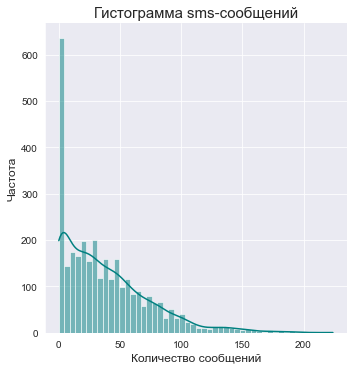


Доля данных с нулевым значением: 0.15


In [9]:
build_plot('messages', 'Гистограмма sms-сообщений', 'Количество сообщений')

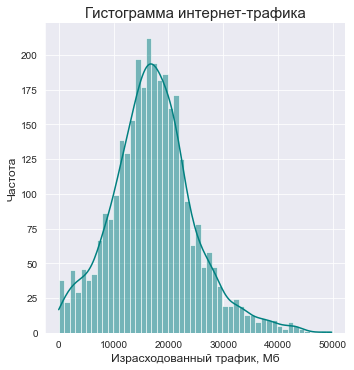


Доля данных с нулевым значением: 0.0


In [10]:
build_plot('mb_used', 'Гистограмма интернет-трафика', 'Израсходованный трафик, Мб')

Посмотрим на взаимосвязи между признаками:

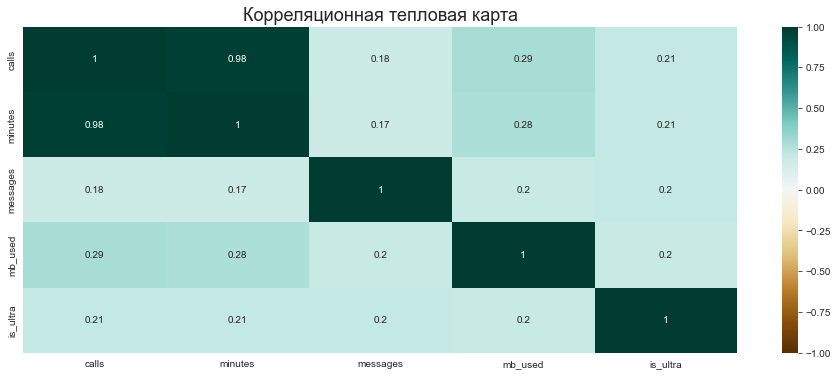

In [11]:
plt.figure(figsize=(16, 6)) 
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Корреляционная тепловая карта', fontsize=18)
plt.show()

**Вывод**

В процессе анализы мы выявили два сильно коррелирующих между собой признака - `calls` и `minutes`. А мультиколлинеарные признаки усложняют интерпретацию модели и как правило ухудшают качество прогнозов. Поскольку признак `calls` не является определяющим фактором для выбора тарифа, мы его удалим.
Также мы обнаружили некоторое количество нулевых значений в остальных признаках. Удалим эти строки для того, чтобы модель могла точнее определить закономерности между признаками


Удалим столбец `calls`

In [12]:
df = df.drop(columns='calls')

 другой вариант
df = df.drop('calls', axis=1)

Сделаем срез данных остальных признаков со значением выше нуля.

In [13]:
df = df.query('messages > 0 and minutes > 0 and mb_used > 0')
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


## Раделение данных на выборки

Перед разделением данных на выборки посмотрим каково распределение доли абонентов, пользующихся тарифом 'Ультра' и тарифом 'Смарт'. Эта информация необходима для проверки соотношения этих долей в новых выборках. Распределение долей в новых выборках для корректной работы модели должно быть близко к первоначальному распределению в исходной выборке.

In [14]:
# функция показывает долю данных по каждому тарифу
def share_of_tariffs(data):
    share = data['is_ultra'].value_counts(normalize=True)
    print('Доля данных о тарифе "Ультра":', round(share[1], 2))
    print('Доля данных о тарифе "Смарт":', round(share[0], 2))

Посмотрим распределение данных по каждому тарифу:

In [15]:
share_of_tariffs(df)

Доля данных о тарифе "Ультра": 0.28
Доля данных о тарифе "Смарт": 0.72


Разделим исходные данные на: 

    1. обучающую выборку - 60%
    2. валидационную выборку - 20%
    3. тестовую выборку - 20%
    
С помощью параметра `random_state =12345` зафиксируем псевдослучайность результата, чтобы можно было повторить удачный эксперимент.

Разделим исходные данные на обучающую выборку - 60% и дополнительную выборку - 40%, которую в следующем шаге разделем поровну на валидационную и тестовую выборки. Для того, чтобы быть уверенным, что таргеты будут разделены в нужном соотношении, используем параметр stratify.

In [16]:
df_train, df_valid_and_test = train_test_split(df, 
                                               test_size=0.4, 
                                               random_state=12345, 
                                               stratify=df['is_ultra'])

In [17]:
df_valid, df_test = train_test_split(df_valid_and_test, 
                                     test_size=0.5, 
                                     random_state=12345, 
                                     stratify=df_valid_and_test['is_ultra'])

Проверим работу stratify на распределение данных по тарифам в наших выборках:

In [18]:
print("Обучающая выборка")
print(share_of_tariffs(df_train))
print()
print("Валидационная выборка")
print(share_of_tariffs(df_valid))
print()
print("Тестовая выборка")
print(share_of_tariffs(df_test))

Обучающая выборка
Доля данных о тарифе "Ультра": 0.28
Доля данных о тарифе "Смарт": 0.72
None

Валидационная выборка
Доля данных о тарифе "Ультра": 0.28
Доля данных о тарифе "Смарт": 0.72
None

Тестовая выборка
Доля данных о тарифе "Ультра": 0.28
Доля данных о тарифе "Смарт": 0.72
None


**Вывод**

Таблица разделена на выборки с тем же сотношением объема данных о тарифах, что и в исходном датасете. 

## Исследование качества моделей

В нашем проекте целлевой признак - это столбец `is_ultra` - где определено каким тарифом пользовался абонент в течение месяца. Поскольку это категориальный целевой признак с двумя категориями, то перед нами стоит задача бинарной классификации.

Чтобы сделать предсказание о том, какой тариф лучше для абонента, нужно понимать взаимосвязи признаков и ответов. 
Мы смоделировали предположение, как устроены эти взаимосвязи. И на этом основании сделаем предсказания - модели машинного обучения.

Для задачи бинарной классификации рассмотрим три модели машинного обучения:
   1. 'Решающее дерево' 
   2. 'Случайный лес'
   3. 'Логистическая регрессия'
   
У моделей машинного обучения есть дополнительные гиперпараметры, меняя которые мы сможем найти оптимальную модель.

Для моделирования выделим в отдельные переменные признаки и целевой признак для каждой выборки.

Создание переменых с признаками и целевым признаком для обучающей выборки:

In [19]:
features_train = df_train.drop('is_ultra', axis = 1)
target_train = df_train['is_ultra']

Создание переменых с признаками и целевым признаком для валидационной выборки:

In [20]:
features_valid = df_valid.drop('is_ultra', axis = 1)
target_valid = df_valid['is_ultra']

Создание переменых с признаками и целевым признаком для тестовой выборки:

In [21]:
features_test = df_test.drop('is_ultra', axis = 1)
target_test = df_test['is_ultra']

### Модель "Дерево решений"

Обучение модели проведем на обучающей выборке и проверим качество предсказаний на валидационной выборке. 

Управлять глубиной дерева в модели 'Дерево решений' будем через гиперпараметр `depth` и попробуем подобрать оптимальную глубину дерева церез цикл.

Определяющий фактор качества модели является доля правильных ответов - `accuracy`.

In [22]:
# создадим переменные для хранения лучших показателей: модели, доли правильных ответов и глубины дерева
best_model = None
best_accuracy = 0
best_depth = 0

# в цикле переберем глубины дерева от 1 до 9 инайдем лучшие показатели качества модели
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)

    if accuracy_valid > best_accuracy:
        best_model = model
        best_depth = depth
        best_accuracy = accuracy_valid
               
print('Лучшая модель:', best_model) 
print('Accuracy лучшей модели:', best_accuracy.round(3))
print('Оптимальная глубина дерева:', best_depth)
   

Лучшая модель: DecisionTreeClassifier(max_depth=4, random_state=12345)
Accuracy лучшей модели: 0.818
Оптимальная глубина дерева: 4


**Вывод**

Лучшая модель "Дерева решений" имеет оптимальную глубину дерева - 4, а доля правильных ответов составляет 0.818.

### Модель "Случайный лес"

Попробуем еще один алгоритм классификации - 'Случайныq лес'. Обучим разное количество независимых друг от друга деревьев и найдем лучшее решение. Обучение модели проведем на обучающей выборке и проверим качество предсказаний на валидационной выборке.

Управлять количеством деревьев в модели будем через гиперпараметр `n_estimators` и постараемся определить оптимальное количество деревьев через цикл.

Определяющий фактор качества модели также является доля правильных ответов - `accuracy`.

In [23]:
best_model = None
best_accuracy = 0
best_est = 0

# в цикле переберем глубины дерева от 1 до 60 инайдем лучшие показатели качества модели
for est in range(1, 61):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)

    if accuracy_valid > best_accuracy:
        best_model = model
        best_est = est
        best_accuracy = accuracy_valid
               
print('Лучшая модель:', best_model) 
print('Accuracy лучшей модели:', best_accuracy.round(3))
print('Оптимальная количество деревьев:', best_est)
   

Лучшая модель: RandomForestClassifier(n_estimators=50, random_state=12345)
Accuracy лучшей модели: 0.846
Оптимальная количество деревьев: 50


**Вывод**

Лучшая модель "Случайный лес" состоит из 50 деревьев, а доля правильных ответов в ней составляет 0.846.

### Модель "Логистическая регрессия"

In [24]:
best_model = None
best_accuracy = 0
best_c = 0

#в цикле переберем регуляризацию от 0.01 до 1 и найдем лучшие показатели качества модели
for reg in np.arange(0.01, 1.0, 0.05):
    model = LogisticRegression(random_state=12345, C=reg)
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)
    if accuracy_valid > best_accuracy:
        best_model = model
        best_c = reg
        best_accuracy = accuracy_valid
print('Доля правильных ответов для логистической регрессии:', accuracy_valid.round(3))
print('Лучшая модель:', best_model) 
print('Регуляризация лучшей модели:', best_c)


Доля правильных ответов для логистической регрессии: 0.735
Лучшая модель: LogisticRegression(C=0.01, random_state=12345)
Регуляризация лучшей модели: 0.01


**Вывод**

Методом перебора моделей и гиперпараметров, выяснили, что лучшей моделью, протестированной на валидационной выборке, является модель "Слйчайный лес", состоящая из 50 деревьев и показывающая долю правильных ответов на уровне - 0.846. Наименьшую долю правильных ответов имеет модель "Логистической регрессии" - 0.735.

### Проверка качества модели

Проверим качество модели на тестовой выборке:

In [25]:
model = RandomForestClassifier(random_state=12345, n_estimators=23)
model.fit(features_train, target_train)
accuracy_test = model.score(features_test, target_test)
print("Доля правильных ответов:", accuracy_test.round(2))


Доля правильных ответов: 0.79


**Вывод**

И на тестовой выборке модель показала достаточно высокую долю правильных ответов на уровне 79%.

## Проверка модели на вменяемость

Проверим модель на адекватность с помощью модели с константным или случайным предсказанием через DummyClassifier

In [26]:
model = DummyClassifier(strategy='most_frequent')
model.fit(features_train, target_train)
model.score(features_valid, target_valid)

0.7185741088180112

**Вывод**

Модель прошла проверку на вменяемость, так ее показатели выше показателей DummyClassifier.

## Вывод

Благодаря проведенному разведочному анализу мы смогли определить мультиколлинеарные признаки и исключить их из данных. А также образужили и удалили данные, которые могли бы усложнить интерпретацию модели и ухудшить качество прогнозов. Тем самым обеспечили модели возможность более точно определить закономерности между признаками и повысить уровень предсказаний.

Мы разделили исходнные данные на выборки: обучающую, валидационную и тестовую, а также выделили для каждой выборки переменные и и целевой признак.  

 Для поставленной задачи - бинарной классификации - подготовили три модели машинного обучения:

1. 'Решающее дерево'
2. 'Случайный лес'
3. 'Логистическая регрессия'

Благодаря начилию дополнительных гиперпараметров у моделей машинного обучения, путем перебора нашли оптимальную модель. 

Это модель "Случайный лес", которая показала высокий уровень предсказаний как на валидационной, так и на тестовой выбоках.
Предсказания модели с долей правильных ответов на тестовой выборке - 79%.

Данную модель можно рекомендовать заказчику для предложения пользователям новых тарифов в соответствии с используемым пакетом услуг.
